In [5]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from keras.utils import OrderedEnqueuer
pd.set_option('display.max_columns', 100)
from sklearn.cross_validation import train_test_split

In [6]:
data=pd.read_csv("cleaned_data.csv",index_col=0,names=["tweet","label"],skiprows=1)
data=data.dropna()
tweets=data["tweet"].tolist()
labels=data["label"].tolist()

In [7]:
stop_words = stopwords.words('english')
parsed=[]
try:
    for sen in tweets:
         parsed.append([txt for txt in word_tokenize(sen.lower()) if txt not in stop_words])
except:
    print sen

In [15]:
model=Word2Vec(parsed,size=50,min_count=1)
model.train(parsed,total_examples=len(data),epochs=10)
weights=model.wv.syn0
vocab_size,embedding_size=weights.shape
my_weights=model.wv.syn0

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """


KeyboardInterrupt: 

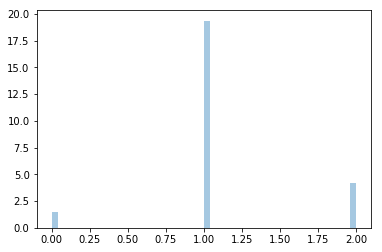

In [16]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,LSTM,Embedding,Activation,Conv1D,Dropout
from keras.activations import sigmoid,softmax
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
sns.distplot(labels)

In [41]:
NEW_Train=np.zeros((len(parsed),29,50))
for j,sen in enumerate(parsed):
     for i,word in enumerate(sen):
        NEW_Train[j,i,:]=model[word]
 



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [43]:

print NEW_Train.shape

(24765, 29, 50)


In [ ]:
def wordtoinx(word):
    return model.wv.vocab[word].index

train_xx=[]
for sen in parsed:
    temp=[]
    for i,word in enumerate(sen):
        temp.append(wordtoinx(word))
    train_xx.append(temp)   
        
train_xx=pad_sequences(train_xx,maxlen=29,padding='post')
train_y=to_categorical(labels)

In [94]:
Train_X,Test_X,Train_Y,Test_Y=train_test_split(train_xx,train_y,test_size=0.2)

print Train_X.shape
print Train_Y.shape

(19812, 29)
(19812, 3)


In [ ]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [95]:
model_k=Sequential()
model_k.add(Embedding(input_dim=18590,output_dim=50,weights=[my_weights],trainable=False))

model_k.add(Conv1D(32,kernel_size=(3)))
model_k.add(Activation('relu'))

model_k.add(LSTM(400,return_sequences=True))
model_k.add(LSTM(200))

model_k.add(Dense(32))
model_k.add(Activation('relu'))
model_k.add(Dropout(0.2))

model_k.add(Dense(3))
model_k.add(Activation('softmax'))

model_k.compile(loss='categorical_crossentropy',metrics=[f1],optimizer="adam")
model_k.summary()
model_k.fit(Train_X,Train_Y,epochs=50,batch_size=32,validation_data=(Test_X,Test_Y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, None, 50)          929500    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 32)          4832      
_________________________________________________________________
activation_52 (Activation)   (None, None, 32)          0         
_________________________________________________________________
lstm_57 (LSTM)               (None, None, 400)         692800    
_________________________________________________________________
lstm_58 (LSTM)               (None, 200)               480800    
_________________________________________________________________
dense_37 (Dense)             (None, 32)                6432      
_________________________________________________________________
activation_53 (Activation)   (None, 32)                0         
__________

KeyboardInterrupt: 

In [ ]:
model_k=Sequential()
# model_k.add(Embedding(input_dim=18590,output_dim=50,weights=[my_weights],trainable=False))

model_k.add(Conv1D(64,kernel_size=(3),input_shape=(29,50)))
model_k.add(Activation('relu'))


model_k.add(LSTM(int(400),input_shape=(29,50),return_sequences=True))
model_k.add(LSTM(400,return_sequences=True))
model_k.add(LSTM(200))

model_k.add(Dense(32))
model_k.add(Activation('relu'))
model_k.add(Dropout(0.2))

model_k.add(Dense(3))
model_k.add(Activation('softmax'))

model_k.compile(loss='categorical_crossentropy',metrics=[f1],optimizer="adam")
model_k.summary()
model_k.fit(Train_X,Train_Y,epochs=50,batch_size=32,validation_data=(Test_X,Test_Y))

In [ ]:
tst="good nice boy"

tst=word_tokenize(tst)
tst=[word for word in tst if word not in stop_words]
i=0
temp=np.zeros((1,29))
print tst
for t in tst:
        print t
        temp[0,i]=wordtoinx(t)
        i=i+1

pred= model_k.predict_classes(temp)
print "class of predicted sentence",pred